In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr, gamma
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# CEL-Seq2 RNA mixture

In [3]:
figprefix = 'figures/Tian_pure'
datadir = '/home/mffang/data/counts/Tian_2019/celseq2/'

In [4]:
c_rna = [1]*6*8 + [2]*14*8 + [4]*14*8 + [8]*14*8
np.var(c_rna)/np.mean(c_rna)**2,np.mean(c_rna),len(c_rna)

(0.3904519164787766, 4.208333333333333, 384)

## Load data

In [5]:
pure = ad.read(datadir + 'counts_unfiltered/adata.h5ad')
pure

AnnData object with n_obs × n_vars = 359 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

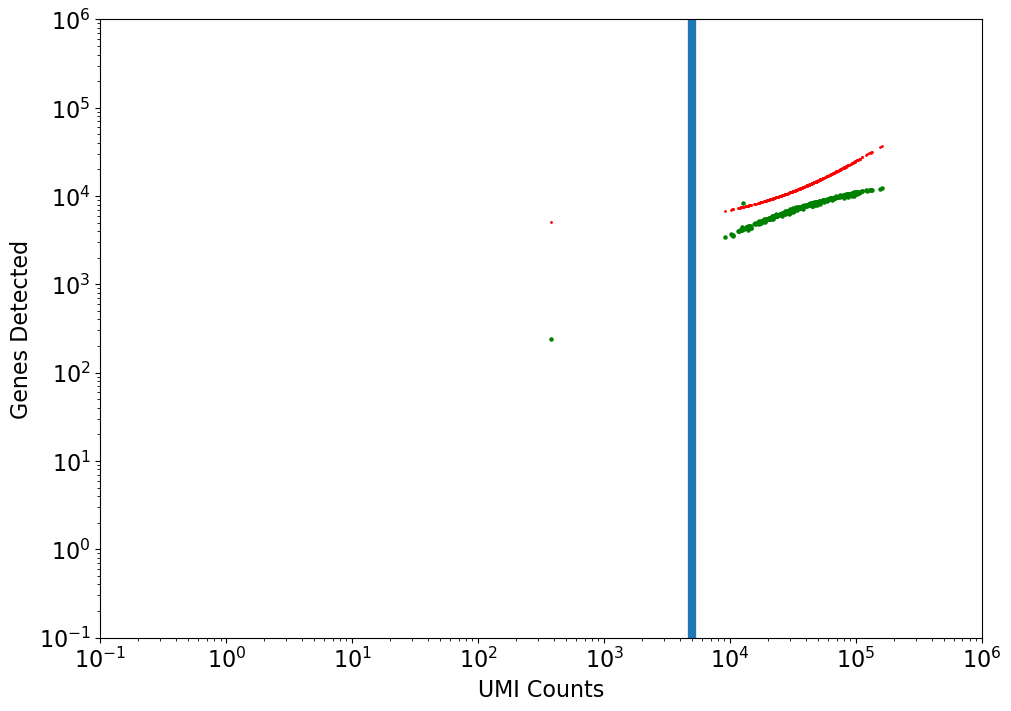

In [7]:
rna = pure.copy()

mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=5, alpha=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,1000000))
ax.set_ylim((0.1,1000000))

ax.scatter(np.asarray(mtx.sum(axis=1)),5000+0.2*np.asarray(mtx.sum(axis=1)),s=1,c='r')
ax.axvline(x=5000)
plt.show()

In [8]:
pure = pure[(mtx.sum(axis=1)>5000) & (np.asarray(np.sum(mtx>0, axis=1)) < 5000+0.2*np.asarray(mtx.sum(axis=1)))]
pure

View of AnnData object with n_obs × n_vars = 357 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

In [9]:
# suppose the wells with lower RNA amount are discard
c_rna = [1]*(6*8-27) + [2]*14*8 + [4]*14*8 + [8]*14*8
s_bio = np.var(c_rna)/np.mean(c_rna)**2
s_bio, len(c_rna)

(0.33317161210192325, 357)

## Normalized covariance

In [10]:
adata = pure.copy()
adata.X = adata.layers['nascent'] + adata.layers['mature'] + adata.layers['ambiguous']
ERCC = adata[:,-92:]
adata = adata[:,:-92]
adata

View of AnnData object with n_obs × n_vars = 357 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

0.12395887 0.17203909 0.86855495


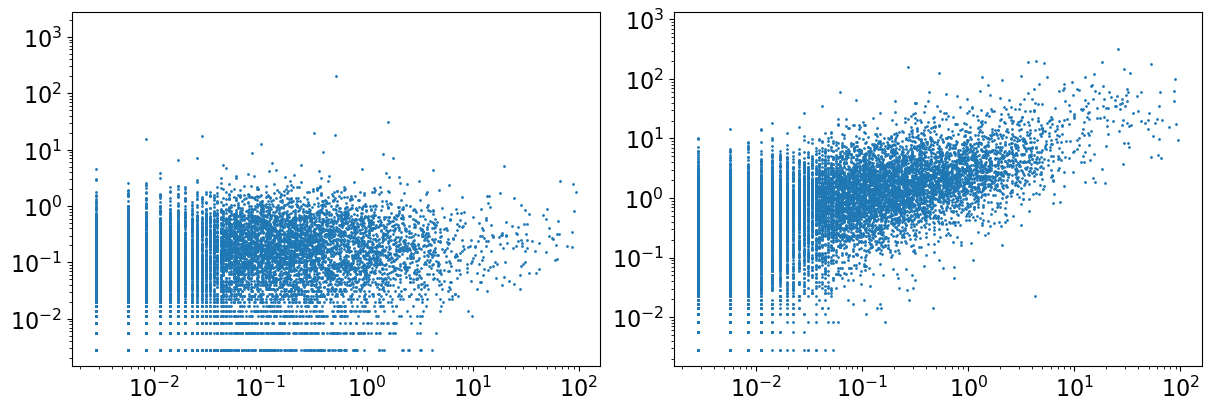

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

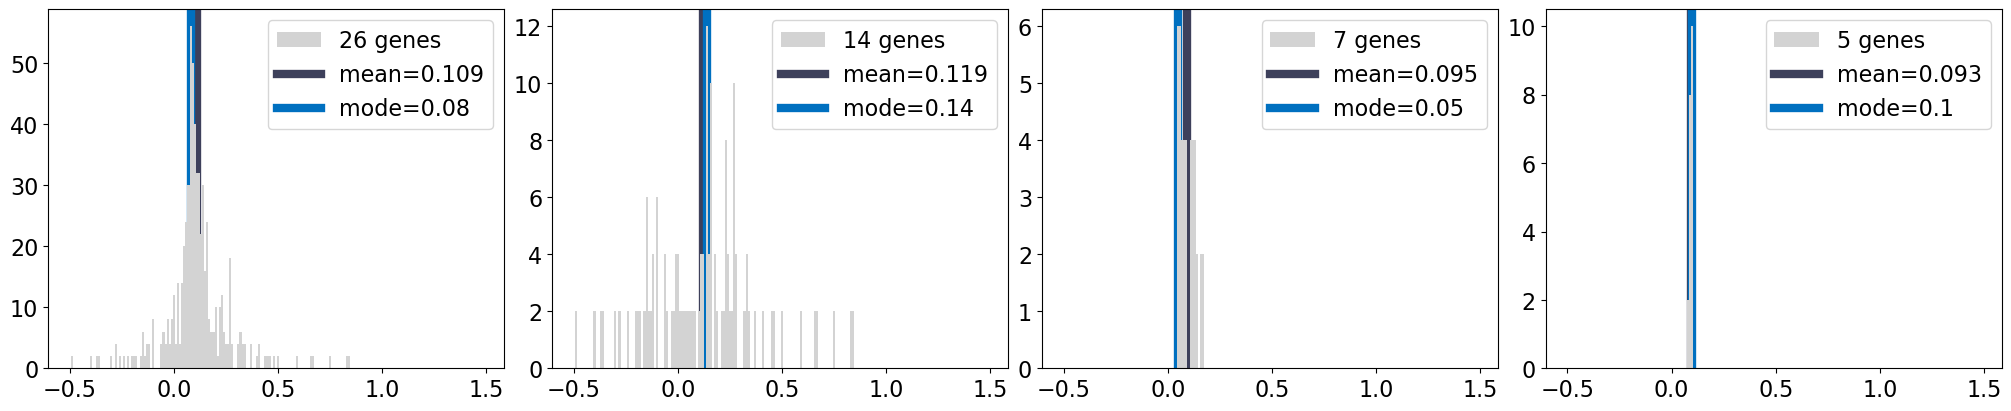

In [14]:
fig,axs = plt.subplots(1,4,figsize=(20,4))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0.1)
s = estimate_s(N1=ERCC.X.toarray(),ax=axs[1],min_mean=0.1,max_mean=1)
s = estimate_s(N1=ERCC.X.toarray(),ax=axs[2],min_mean=1,max_mean=10)
s = estimate_s(N1=ERCC.X.toarray(),ax=axs[3],min_mean=10)

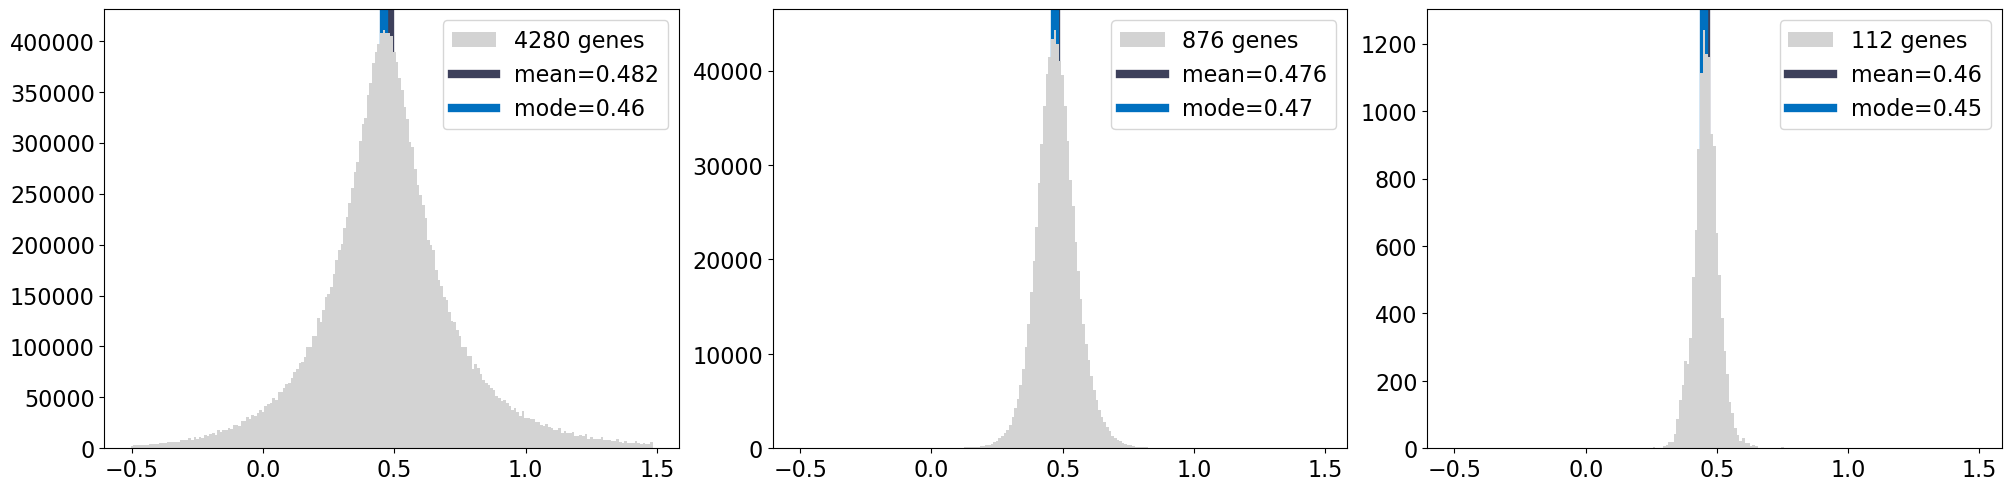

In [15]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,bins=np.arange(-0.5,1.5,0.01)-0.005)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-0.5,1.5,0.01)-0.005)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf,bins=np.arange(-0.5,1.5,0.01)-0.005)

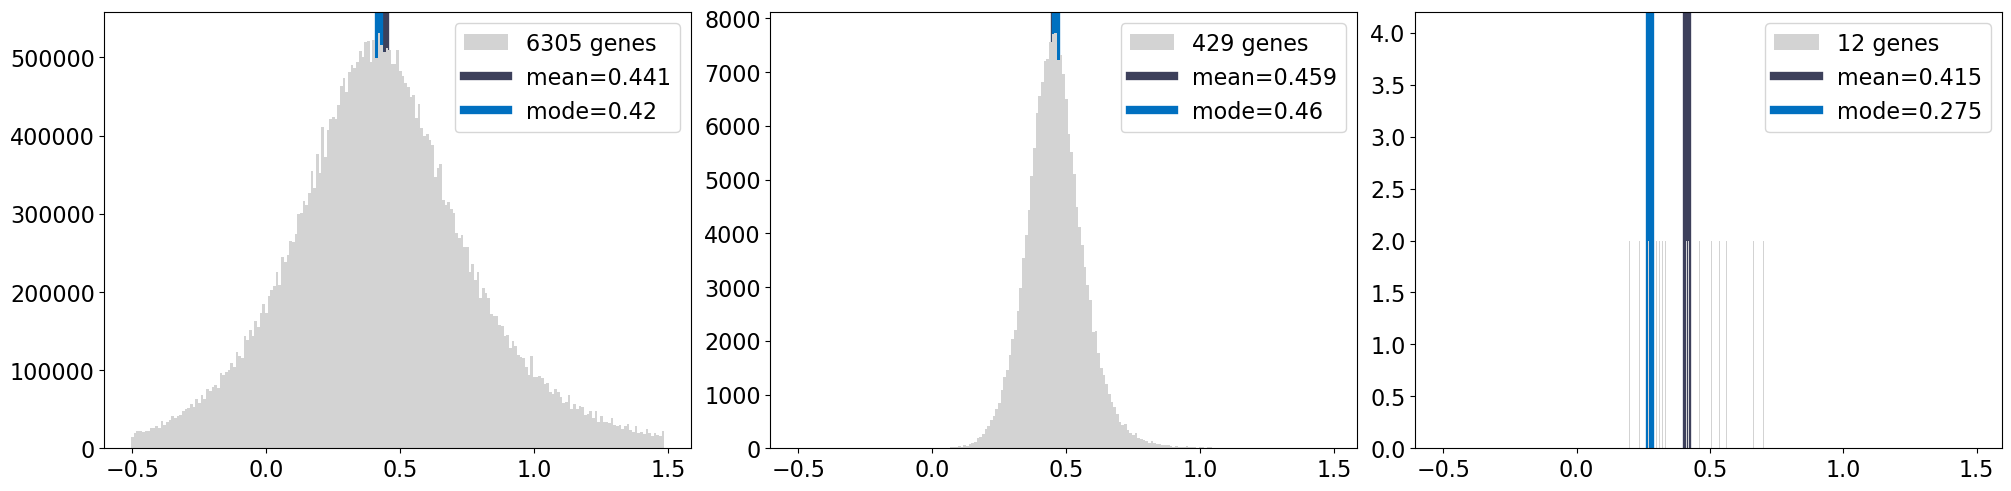

In [16]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-0.5,1.5,0.01)-0.005)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-0.5,1.5,0.01)-0.005)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf,bins=np.arange(-0.5,1.5,0.001)-0.005)

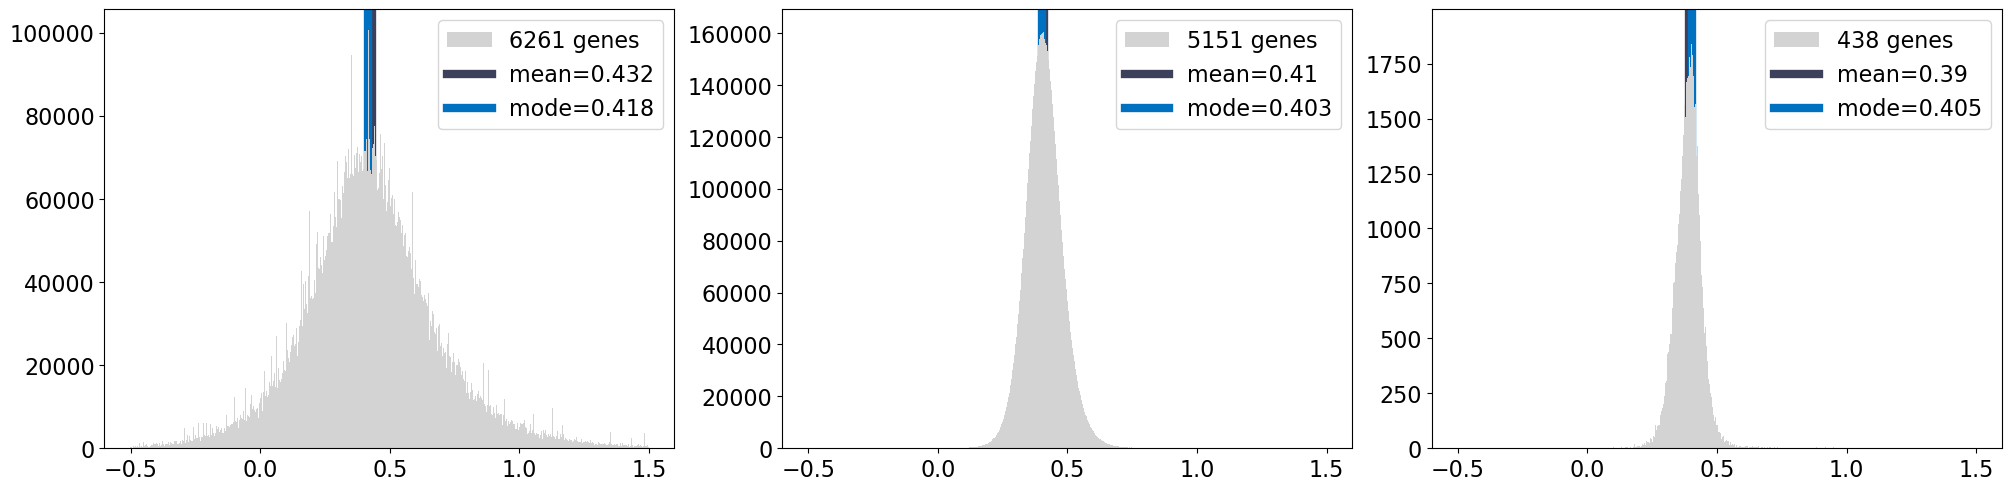

In [17]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-0.5,1.5,0.001)-0.0005)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf,bins=np.arange(-0.5,1.5,0.001)-0.0005)

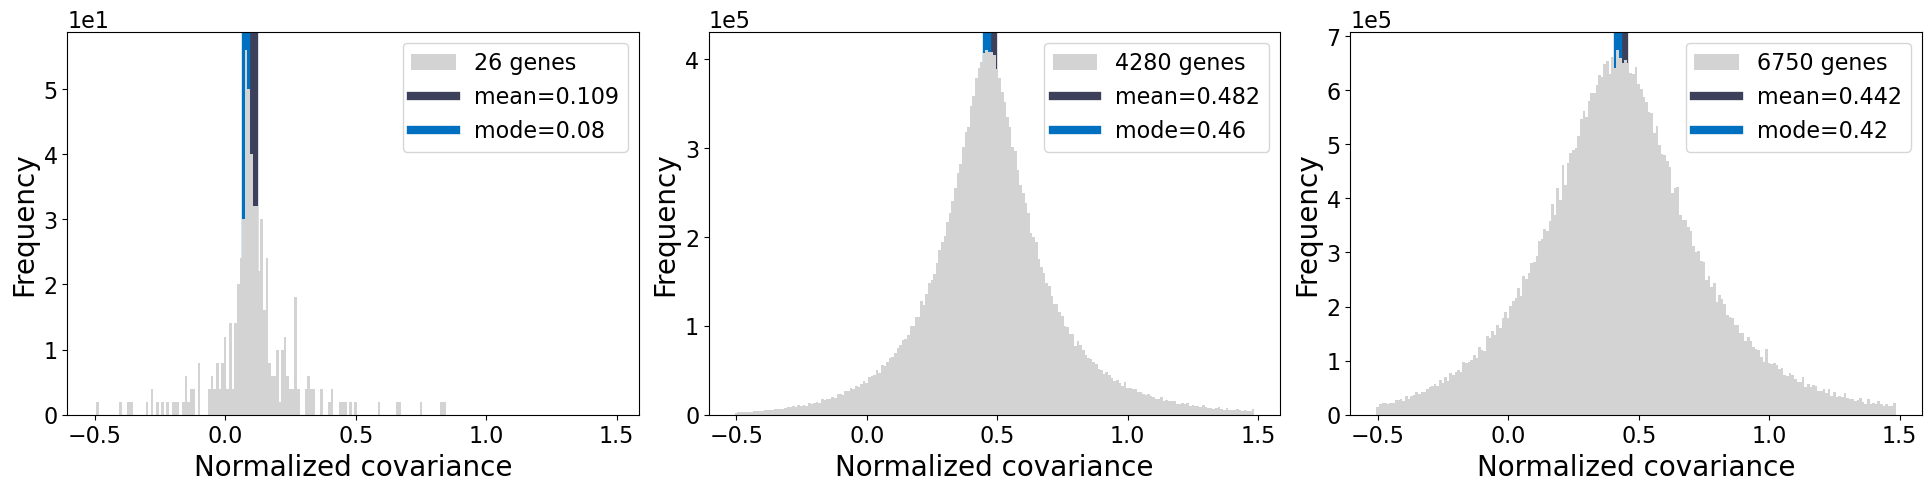

In [18]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0.1)
s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

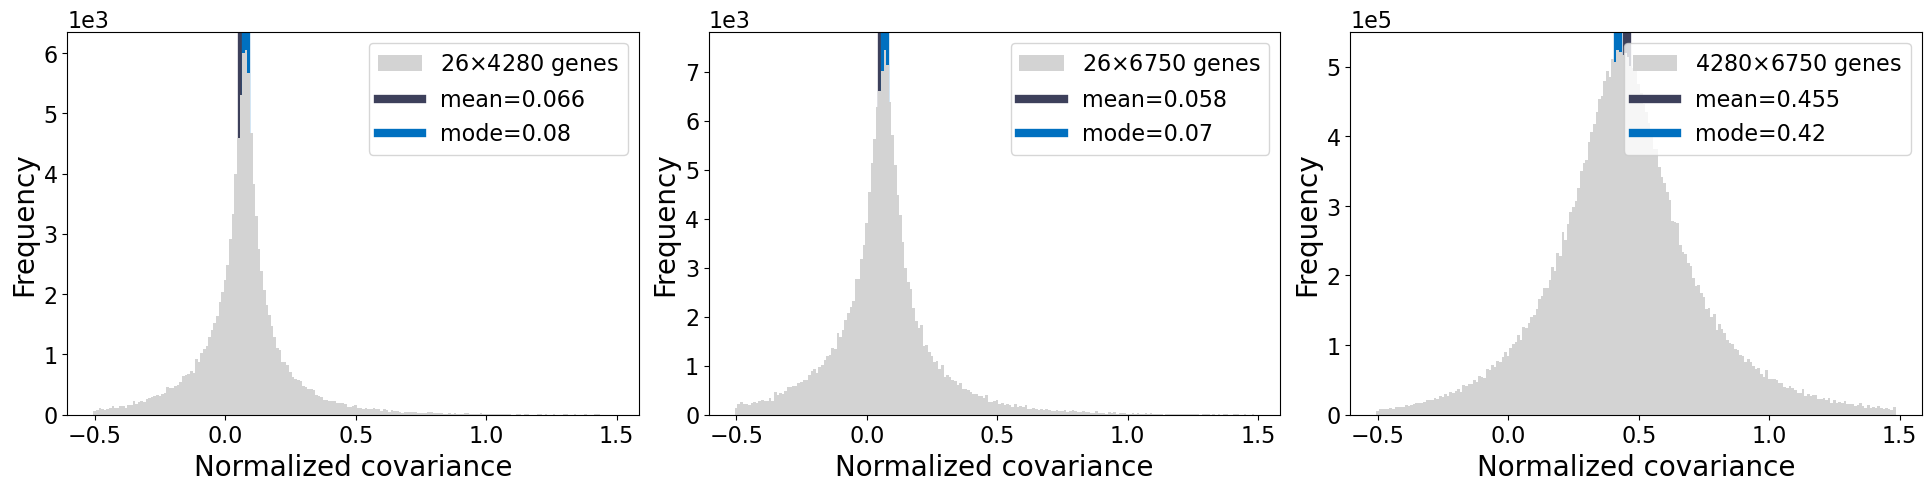

In [19]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=ERCC.X.toarray(),N2=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1)
s = estimate_s(N1=ERCC.X.toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

In [20]:
s_bio,1.46/1.08-1

(0.33317161210192325, 0.35185185185185164)

## Bootstrap s

In [15]:
s_bootstrap = bootstrapping_s(ERCC.X.toarray(),adata.X.toarray(),B=1000,seed=0,n_cores=40)

100%|██████████| 1000/1000 [00:00<00:00, 2651266.75it/s]


In [16]:
s_bio = (s_bootstrap[:,1]+1)/(1+s_bootstrap[:,0])-1
(s_bio > 0.335).sum()

73

Text(0.5, 0, 'Values')

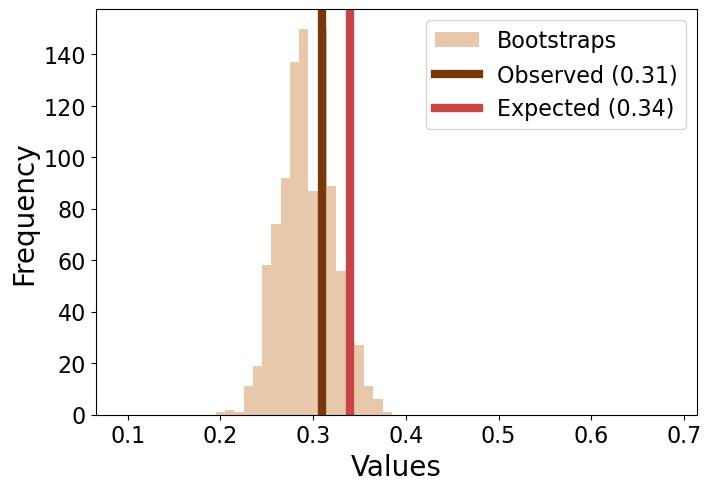

In [18]:
plt.figure(figsize=(7,4.8))
plt.hist(s_bio,bins=np.arange(0.1,0.7,0.01)-0.005,color='#d09259',alpha=0.5,label='Bootstraps')
plt.axvline(x=0.31,color='#78380c',label='Observed (0.31)')
plt.axvline(x=0.34,color='#c74546',label='Expected (0.34)')
plt.legend()
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Values',fontsize=20)

## Varaince plot

In [21]:
se = 0.08
su = 0.42
ss = 0.46

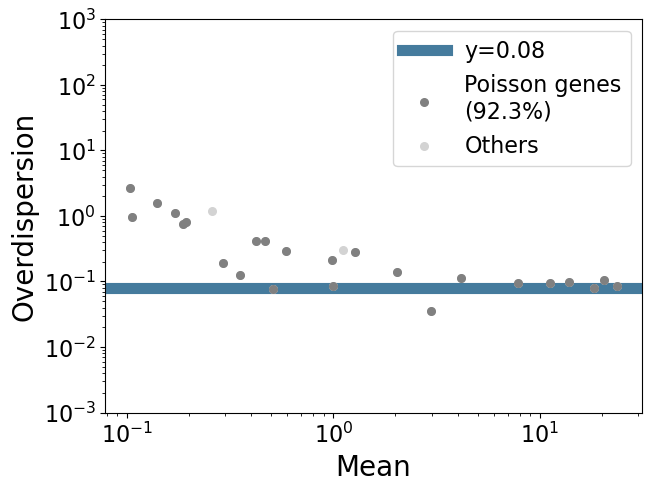

In [32]:
s = se
X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=10)
E_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='upper right',fontsize=16);

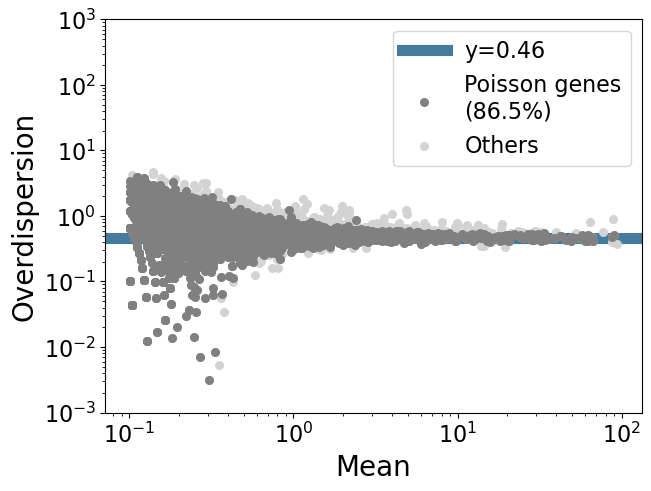

In [33]:
s = ss
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=10)
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='upper right',fontsize=16);

/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean


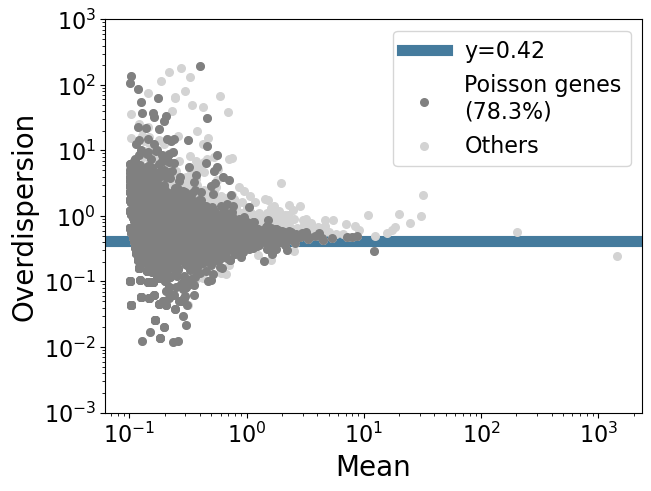

In [34]:
s = su
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=10)
U_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = U_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='upper right',fontsize=16);

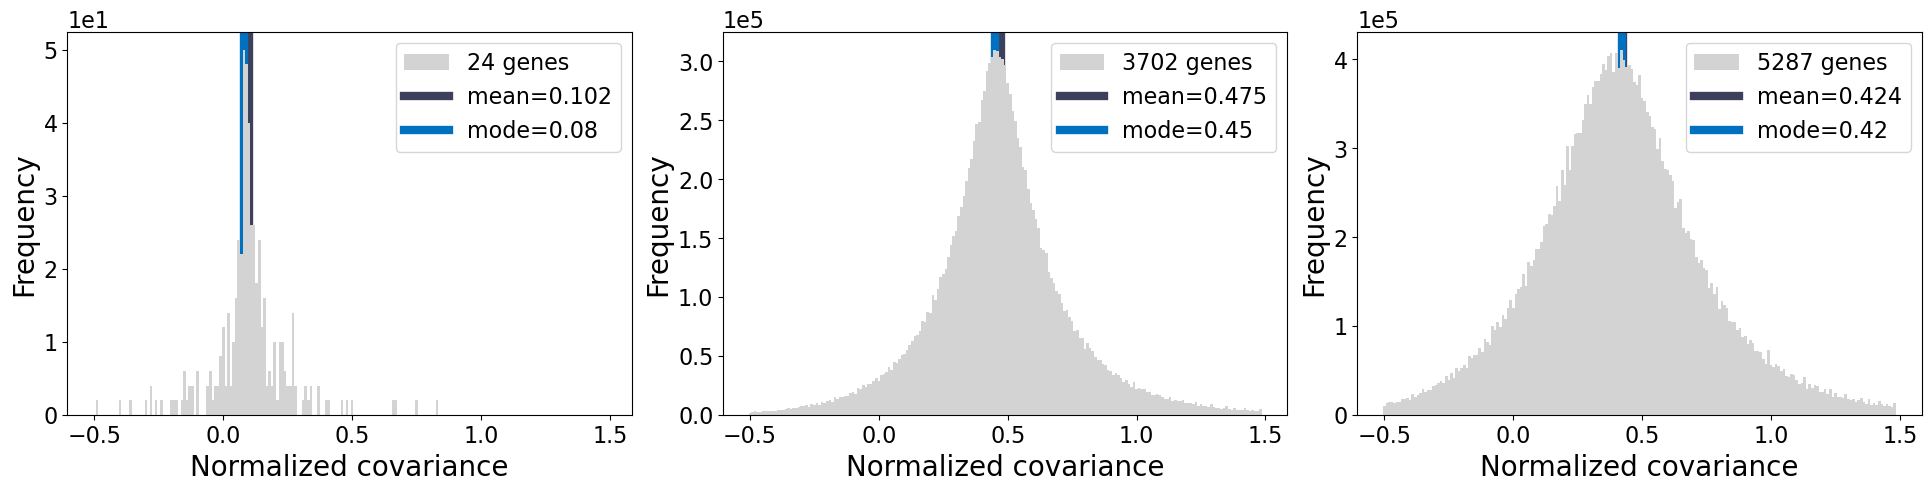

In [38]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = E_Pgene_mask.copy()
X_E = X_[:,nonzero_idx][:,Pgene_mask]
s = estimate_s(X_E,ax=axs[0])

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = S_Pgene_mask.copy()
X_S = X_[:,nonzero_idx][:,Pgene_mask]
s = estimate_s(X_S,ax=axs[1])

X_ = adata.layers["nascent"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgene_mask = U_Pgene_mask.copy()
X_U = X_[:,nonzero_idx][:,Pgene_mask]
s = estimate_s(X_U,ax=axs[2])

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

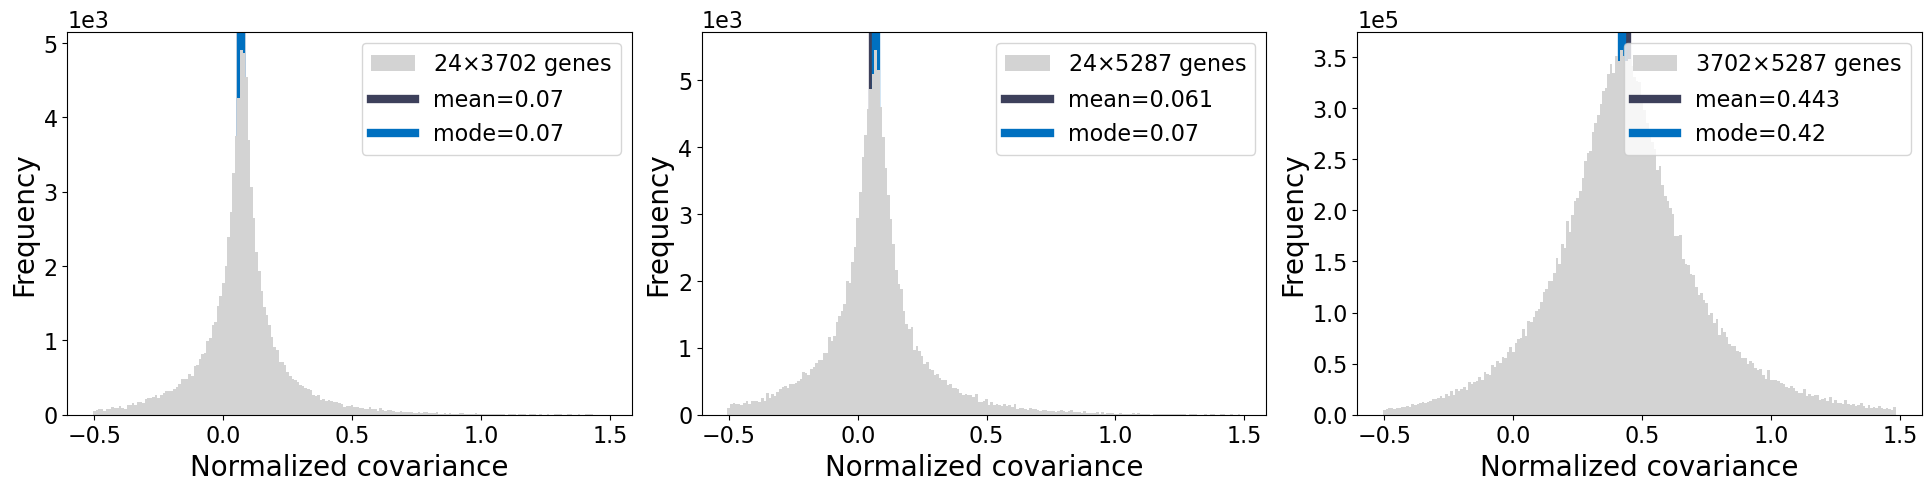

In [39]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=X_E,N2=X_S,ax=axs[0])
s = estimate_s(N1=X_E,N2=X_U,ax=axs[1])
s = estimate_s(N1=X_S,N2=X_U,ax=axs[2])

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

## Droplet size

r=0.99


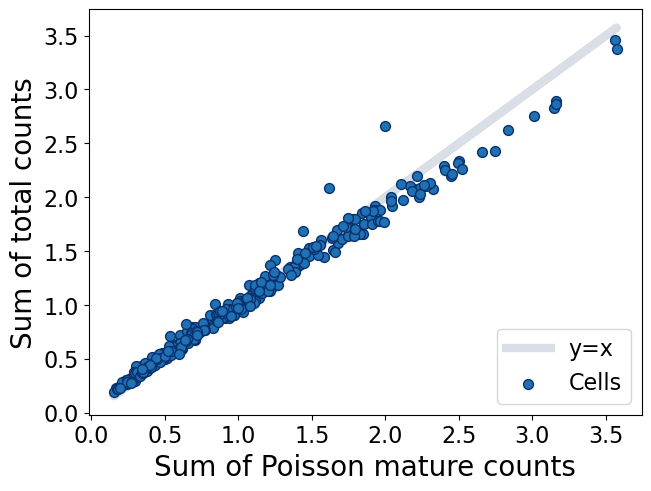

In [42]:
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,S_Pgene_mask].sum(1)

X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_U = X_[:,U_Pgene_mask].sum(1)

cellsize_X = adata.X.toarray().copy().sum(1)

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,alpha=1,s=50,c='#2070b4',edgecolor='#08326e',label='Cells')
           
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Sum of Poisson mature counts',fontsize=20)
plt.ylabel('Sum of total counts',fontsize=20)
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

In [44]:
s = se
X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
c_tech = X_[:,E_Pgene_mask].sum(1)
c_tech = c_tech/c_tech.mean()

Text(0.5, 0, 'Values')

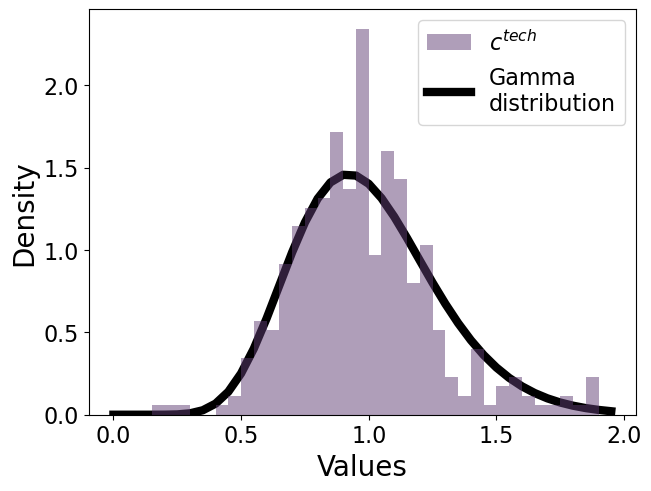

In [47]:
x = np.arange(0,2,0.05)
ds = c_tech
plt.hist(ds,bins=x,density=True,color='#613f75',alpha=0.5,label=r'$c^{tech}$');
plt.plot(x,gamma.pdf(x,a=1/se,scale=se),c='k',zorder=0,label='Gamma\ndistribution')
#plt.plot(x,norm.pdf(x,loc=1,scale=np.sqrt(ss)),c='#3d405b',zorder=0,label='Gaussian')
plt.legend(fontsize=16)
plt.ylabel('Density',fontsize=20)
plt.xlabel('Values',fontsize=20)

In [48]:
c = cellsize_S
c_b = c/c_tech
c_b = c_b[~np.isinf(c_b)]
c_b = c_b/c_b.mean()
np.var(c_b), c_tech.var(), c.var()

(0.38732713, 0.09994701, 11350159.0)

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_4092401/489209366.py:2: SyntaxWarning: invalid escape sequence '\h'
  plt.hist([c_b,c_rna/np.mean(c_rna)],bins=x,density=True,color=['gray','#C8691C'],alpha=0.75,label=['$\hat{c}^{bio}$','Expected'])


Text(0.5, 0, 'Values')

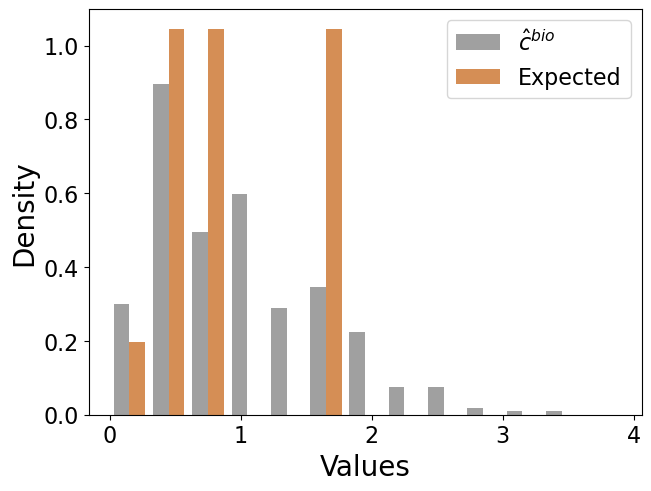

In [49]:
x = np.arange(0,4,0.3)
plt.hist([c_b,c_rna/np.mean(c_rna)],bins=x,density=True,color=['gray','#C8691C'],alpha=0.75,label=['$\hat{c}^{bio}$','Expected'])
plt.legend(fontsize=16)

plt.ylabel('Density',fontsize=20)
plt.xlabel('Values',fontsize=20)

In [50]:
c_bio_ = np.sort(list(set(c_rna)))/np.mean(c_rna)

Text(0.5, 0, '$\\hat{c}^{bio}$')

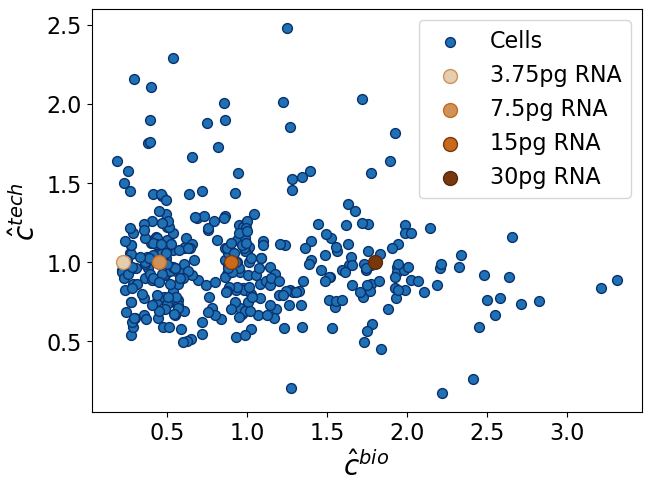

In [53]:
plt.scatter(c_b/c_b.mean(),c_tech[c_tech>0],alpha=1,s=50,c='#2070b4',edgecolor='#08326e',label='Cells')
plt.scatter(c_bio_[0],[1],s=100,c='#e4ceaf',edgecolor='#d09259',label='3.75pg RNA')
plt.scatter(c_bio_[1],[1],s=100,c='#d09259',edgecolor='#c8691c',label='7.5pg RNA')
plt.scatter(c_bio_[2],[1],s=100,c='#c8691c',edgecolor='#78380c',label='15pg RNA')
plt.scatter(c_bio_[3],[1],s=100,c='#78380c',edgecolor='#562a0e',label='30pg RNA')
plt.legend()
plt.ylabel(r'$\hat{c}^{tech}$',fontsize=20)
plt.xlabel(r'$\hat{c}^{bio}$',fontsize=20)

## Simulation check

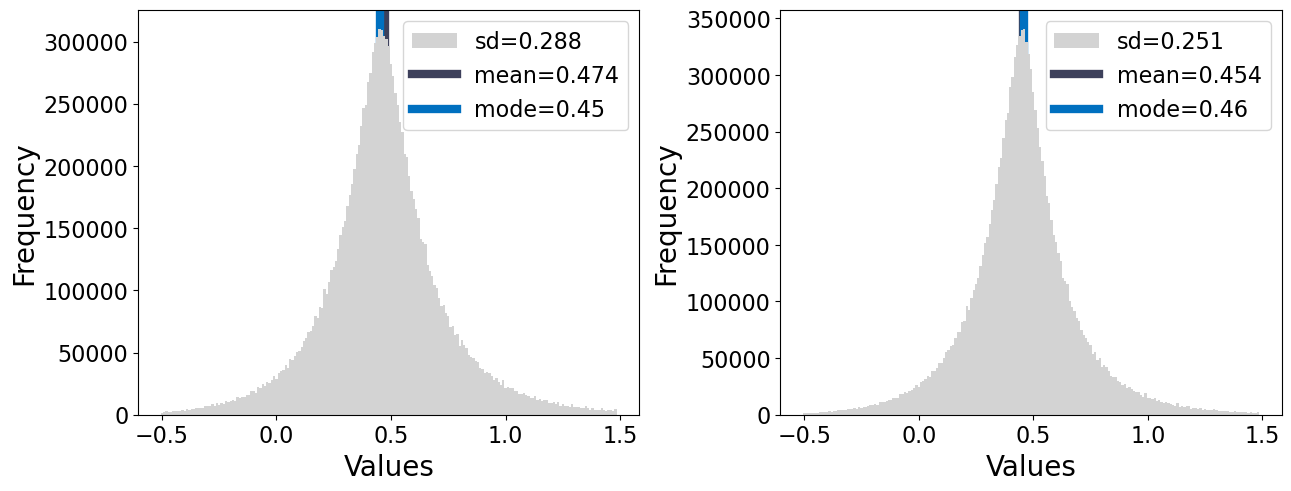

In [140]:
c = cellsize_S/cellsize_S.mean()
lam = X_S.mean(0)
np.random.seed(2025)
XX = np.random.poisson(c[:,None]*lam[None,:])

fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_S,ax=axs[0])
s_nn = estimate_s_(N1=XX,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

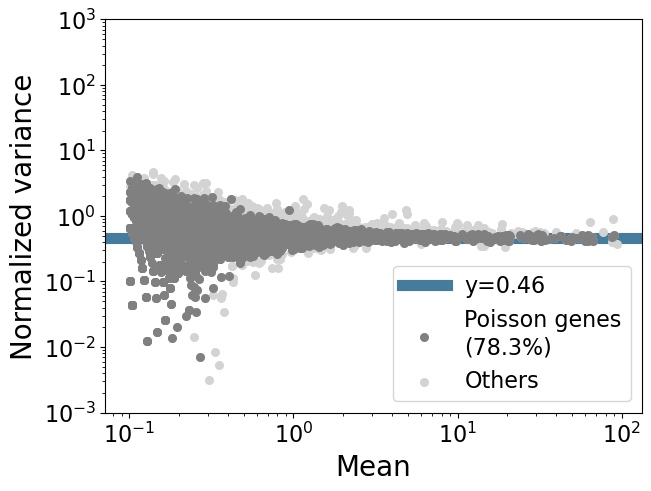

In [167]:
s = ss
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=10,alpha=0.1)
M_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = M_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

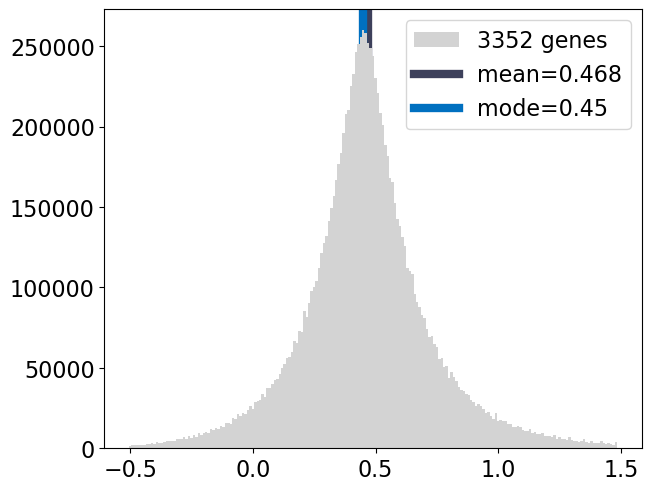

In [168]:
fig,axs = plt.subplots(1,1)

X_S = X_[:,Pgene_mask]
s = estimate_s(X_S,ax=axs)

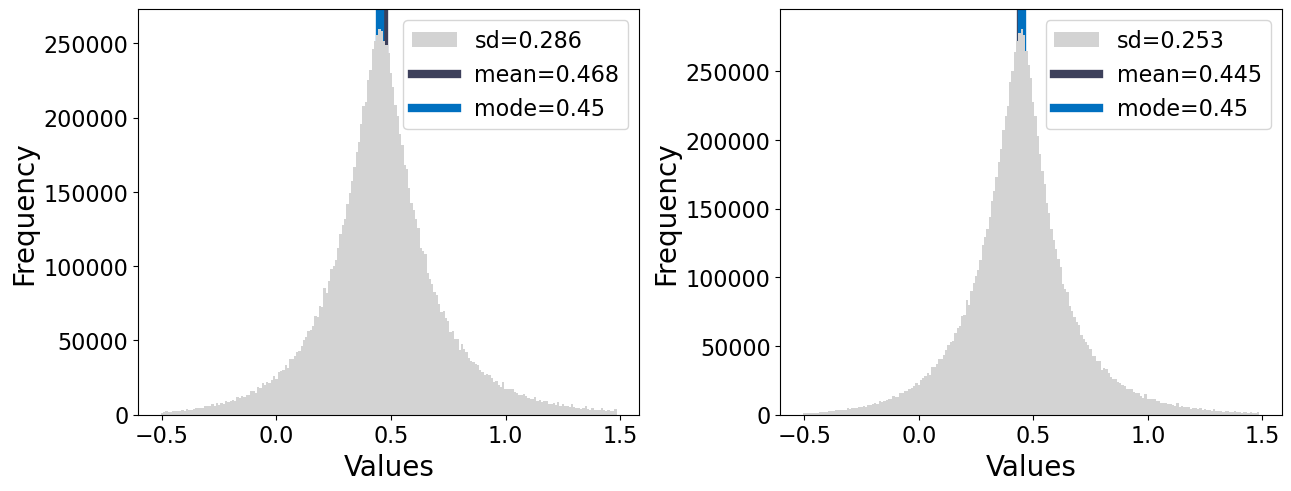

In [169]:
cellsize_S = X_S.sum(1)
c = cellsize_S/cellsize_S.mean()
lam = X_S.mean(0)
np.random.seed(2025)
XX = np.random.poisson(c[:,None]*lam[None,:])

fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_S,ax=axs[0])
s_nn = estimate_s_(N1=XX,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

## Covariance relationships

In [15]:
idx = adata.var_names.isin(adata.var_names)

N = adata.layers["nascent"][:,idx].toarray()
M = adata.layers["mature"][:,idx].toarray() 

idx = (N.mean(0)>0.1) & (M.mean(0)>0.1)
N = N[:,idx]
M = M[:,idx]

M_mean = np.mean(M,axis=0)
N_mean = np.mean(N,axis=0)

M_var = np.var(M,axis=0)
N_var = np.var(N,axis=0)

zeta_nn = (N_var-N_mean)/N_mean**2
zeta_mm = (M_var-M_mean)/M_mean**2

cov_nm = []
for i in np.arange(len(N_mean)):
    cov_nm.append(np.cov(N[:,i],M[:,i])[0,1])
    
zeta_nm = np.array(cov_nm)/M_mean/N_mean
zeta_nm.shape

(2570,)

Text(0.5, 1.0, '88.28% of 256 genes > 0')

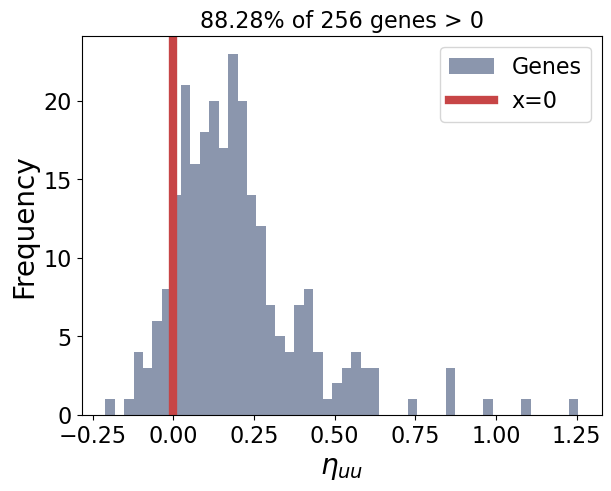

In [148]:
plt.figure(figsize=(6,4.8))
plt.hist(zeta_uu,bins=50,color=gray,label='Genes');
plt.axvline(x=0,c=red,label='x=0')
plt.xlabel(r'$\eta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
plt.title(str(np.around(100*(zeta_uu>0).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0',fontsize=legend_font)
#plt.savefig(figprefix+"_uu.pdf", dpi=150)

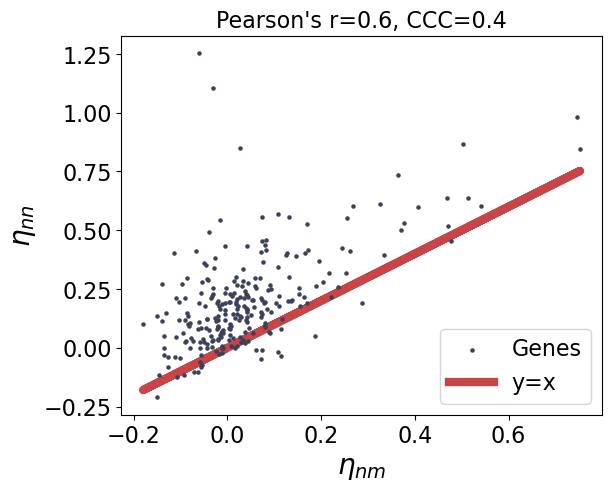

In [168]:
x=zeta_us
y=zeta_uu

plt.figure(figsize=(6,4.8))
plt.scatter(x,y,s=5,label='Genes',color='#3d405b')
plt.plot(x,x,zorder=0,c=red,label='y=x')
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)),fontsize=legend_font);
#plt.colorbar(label='1/mean')
plt.legend()
plt.xlabel(r'$\eta_{nm}$',fontsize=label_font);
plt.ylabel(r'$\eta_{nn}$',fontsize=label_font);
#plt.savefig(figprefix+"_us.pdf", dpi=150)

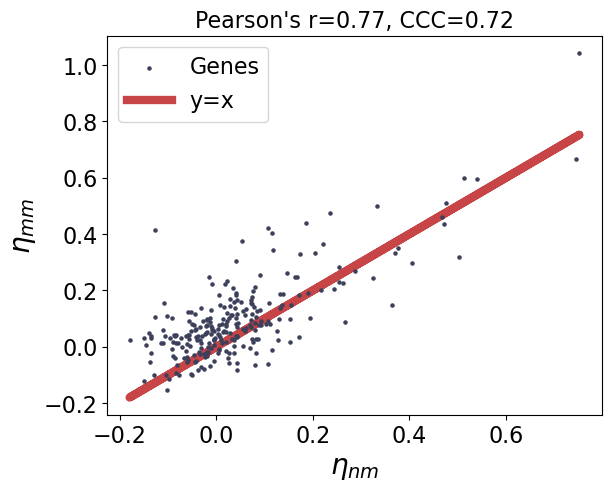

In [167]:
x=zeta_us
y=zeta_ss

plt.figure(figsize=(6,4.8))
plt.scatter(x,y,s=5,label='Genes',color='#3d405b')
plt.plot(x,x,zorder=0,c=red,label='y=x')
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)),fontsize=legend_font);
#plt.colorbar(label='1/mean')
plt.legend()
plt.xlabel(r'$\eta_{nm}$',fontsize=label_font);
plt.ylabel(r'$\eta_{mm}$',fontsize=label_font);
#plt.savefig(figprefix+"_us.pdf", dpi=150)

In [16]:
lower_bound, upper_bound, delta_eta_bootstrap = bootstrapping_func(delta_eta,[N,M],B=1000,n_cores=50)
Null_gene_mask = (0 < upper_bound) & (0 > lower_bound) 
Null_gene_mask.mean()

100%|██████████| 1000/1000 [00:07<00:00, 129.20it/s]


0.9042801556420234

Pearson's r=0.149, CCC=0.112


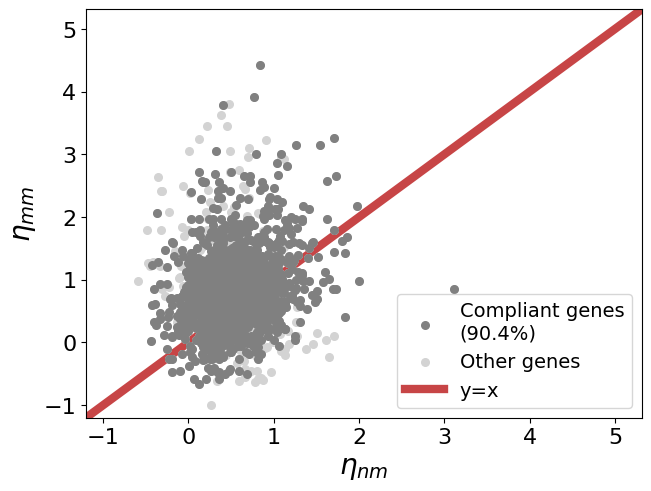

In [17]:
x=zeta_nm
y=zeta_mm

all_data = np.concatenate([x, y])
min_val, max_val = all_data.min()*1.2, all_data.max()*1.2

plt.figure(figsize=(6.4,4.8))
plt.scatter(x[Null_gene_mask],y[Null_gene_mask],s=30,zorder=2,color='gray',label='Compliant genes\n('+str(np.around(100*np.mean(Null_gene_mask),1))+"%)")
plt.scatter(x,y,s=30,color='lightgray',zorder=1,label='Other genes')
plt.plot([min_val, max_val],[min_val, max_val],zorder=0,c=red,label='y=x')
plt.legend(loc='lower right',fontsize=14);
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel(r'$\eta_{nm}$',fontsize=20);
plt.ylabel(r'$\eta_{mm}$',fontsize=20);
#plt.savefig(figprefix+"_us.pdf", dpi=150)
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,3))+", CCC="+str(np.round(CCC(x,y),3)))